# PV Secondary Targeting

Parse a set of PV observations created using the script

`/path/to/timedomain/bin/td_from_program PV > pv_tgt.out`

In [1]:
import os
from astropy.io import ascii, fits
from astropy.table import join, hstack, vstack, Table

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
mpl.rc('font', size=16)

## Load PV Target ASCII DB

Load the PV secondary targets from an ASCII file.
Then plot the data.

In [3]:
pv_targets = ascii.read('pv_tgt.out', delimiter='|',
                        names=['PROGRAM', 'RA', 'DEC', 'TARGETID', 'TILEID', 'DATE', 'PETAL'])
pv_targets

PROGRAM,RA,DEC,TARGETID,TILEID,DATE,PETAL
str14,float64,float64,int64,int64,int64,int64
PV_BRIGHT_HIGH,149.171684545314,2.16060616970239,1070167824007172,13,20210407,3
PV_BRIGHT_HIGH,149.658076810033,0.868788172013763,1070131593609233,14,20210408,1
PV_BRIGHT_HIGH,150.356606634878,3.59611185445412,1070198031384587,14,20210408,5
PV_BRIGHT_HIGH,150.267396959543,3.33093628066686,1070191999975425,14,20210408,5
PV_BRIGHT_HIGH,151.099800148199,2.56094576885652,1070173897359360,14,20210408,7
PV_BRIGHT_HIGH,151.403281837345,1.84924206413151,1070155782160385,14,20210408,8
PV_BRIGHT_HIGH,151.006785108655,1.62447667017721,1070149738168328,14,20210408,9
PV_BRIGHT_HIGH,151.145673966004,1.52285422698331,1070149738168325,14,20210408,9
PV_BRIGHT_HIGH,150.823041569144,1.50048971567638,1070149733974017,14,20210408,9


In [4]:
def plot_radec(table):
    """Mollweide projection plot adapted to astro coordinates.
    
    Parameters
    ----------
    table : astropy.table.Table
        Data table with secondary target info.
    
    Returns
    -------
    fig : matplotlib.Figure
        Figure object to let user apply further plot manipulation.
    """
    fig, ax = plt.subplots(1,1, figsize=(8,4), subplot_kw={'projection': 'mollweide'})
    
    # Loop through unique classes.
    class_names = np.unique(table['PROGRAM'])
    for class_name in class_names:
        select = table['PROGRAM'] == class_name
        
        # Convert RA, Dec to radians.
        # Rotate the RA so that the plot goes 360->0 left to right.
        _ra = np.radians(180. - table[select]['RA'])
        _dec = np.radians(table[select]['DEC'])
        ax.scatter(_ra, _dec, alpha=0.5, s=5, label=class_name)

    # Clean up the plot and return the Figure object.
    ax.set(xticks=np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150]),
           xticklabels=['22h', '20h', '18h', '16h', '14h', '12h', '10h', '8h', '6h', '4h', '2h'])
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.grid(ls=':')
    
    ax.legend(fontsize=8, loc='lower right')
    fig.tight_layout()

    return fig;

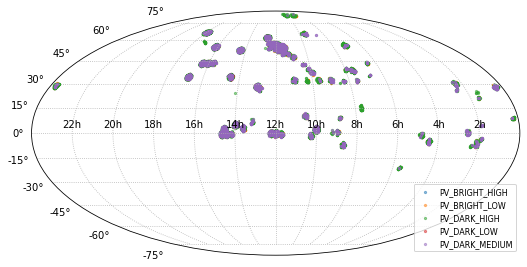

In [5]:
fig = plot_radec(pv_targets)

## Extract Object Redshifts

For each object in the table, extract the redshift. There is an efficient way to do this and a stupid way. Let's get stupid.

In [12]:
redux = 'daily'

ztable = None

for i, pv_target in enumerate(pv_targets):
    zbdir = '{}/{}/tiles/{}/{}'.format(os.environ['DESI_SPECTRO_REDUX'], redux, pv_target['TILEID'], pv_target['DATE'])
    zbfile = '{}/zbest-{}-{}-{}.fits'.format(zbdir, pv_target['PETAL'], pv_target['TILEID'], pv_target['DATE'])
    if os.path.exists(zbfile):
        hdus = fits.open(zbfile)
        zbest = hdus['ZBEST'].data
        select = zbest['TARGETID'] == pv_target['TARGETID']
        if ztable is None:
            ztable = join(pv_target, zbest[select], keys='TARGETID')
        else:
            ztable = vstack([ztable, join(pv_target, zbest[select], keys='TARGETID')])
            
    if (i+1)%100 == 0:
        print('{} out of {}'.format(i+1, len(pv_targets)))

100 out of 19697
200 out of 19697
300 out of 19697
400 out of 19697
500 out of 19697
600 out of 19697
700 out of 19697
800 out of 19697
900 out of 19697
1000 out of 19697
1100 out of 19697
1200 out of 19697
1300 out of 19697
1400 out of 19697
1500 out of 19697
1600 out of 19697
1700 out of 19697
1800 out of 19697
1900 out of 19697
2000 out of 19697
2100 out of 19697
2200 out of 19697
2300 out of 19697
2400 out of 19697
2500 out of 19697
2600 out of 19697
2700 out of 19697
2800 out of 19697
2900 out of 19697
3000 out of 19697
3100 out of 19697
3200 out of 19697
3300 out of 19697
3400 out of 19697
3500 out of 19697
3600 out of 19697
3700 out of 19697
3800 out of 19697
3900 out of 19697
4000 out of 19697
4100 out of 19697
4200 out of 19697
4300 out of 19697
4400 out of 19697
4500 out of 19697
4600 out of 19697
4700 out of 19697
4800 out of 19697
4900 out of 19697
5000 out of 19697
5100 out of 19697
5200 out of 19697
5300 out of 19697
5400 out of 19697
5500 out of 19697
5600 out of 19697
5

In [13]:
ztable

PROGRAM,RA,DEC,TARGETID,TILEID,DATE,PETAL,CHI2,COEFF [10],Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,NCOEFF,DELTACHI2,NUMEXP,NUMTILE
str14,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,int64,int64,str6,str20,int64,float64,int32,int32
PV_BRIGHT_HIGH,149.171684545314,2.16060616970239,1070167824007172,13,20210407,3,8.999999999999996e+99,0.0 .. 0.0,-0.0019956912923479522,4.1311493573349107e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,1
PV_BRIGHT_HIGH,149.658076810033,0.868788172013763,1070131593609233,14,20210408,1,8469.749970858873,237.75789083567935 .. 18.021563291706393,0.038746598824725795,0.00010953448354655893,0,7877,GALAXY,,10,46.27306709883487,0,1
PV_BRIGHT_HIGH,150.356606634878,3.59611185445412,1070198031384587,14,20210408,5,8.999999999999996e+99,0.0 .. 0.0,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,1
PV_BRIGHT_HIGH,150.267396959543,3.33093628066686,1070191999975425,14,20210408,5,8.999999999999996e+99,0.0 .. 0.0,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,1
PV_BRIGHT_HIGH,151.099800148199,2.56094576885652,1070173897359360,14,20210408,7,8251.109564840794,19.882904297979948 .. 11.817713694117097,0.9054548849070341,9.606776362361803e-05,4,7866,GALAXY,,10,1.047316625714302,0,1
PV_BRIGHT_HIGH,151.403281837345,1.84924206413151,1070155782160385,14,20210408,8,8226.589183844626,405.24166554708387 .. 13.374131213465573,0.3553936270155521,6.568253711579781e-05,0,7928,GALAXY,,10,12.802025880664587,0,1
PV_BRIGHT_HIGH,151.006785108655,1.62447667017721,1070149738168328,14,20210408,9,8119.4517160877585,-39.3437353346159 .. 13.718172020606795,0.5659037711076511,9.600278705613211e-05,4,7889,GALAXY,,10,1.7127878293395042,0,1
PV_BRIGHT_HIGH,151.145673966004,1.52285422698331,1070149738168325,14,20210408,9,8.999999999999996e+99,0.0 .. 0.0,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,CV,3,1.942668892225729e+84,0,1
PV_BRIGHT_HIGH,150.823041569144,1.50048971567638,1070149733974017,14,20210408,9,8265.773368000984,14.977162978802948 .. -23.413107338214203,0.22985611450182714,5.206470446416618e-05,4,7889,GALAXY,,10,0.5678329467773438,0,1


### Output Redrock Spectral Types

In [28]:
types_, counts_ = np.unique(ztable['SPECTYPE'], return_counts=True)
for t, c in zip(types_, counts_):
    print('{:10s} : {:10d} ({:.1f}%)'.format(t, c, 100*c/len(ztable)))

GALAXY     :      17397 (88.3%)
QSO        :        174 (0.9%)
STAR       :       2126 (10.8%)


## Write Output

### FITS Format

This format is needed to preserve the redrock template coefficients in the output, should they be needed for spectral matching and plotting later.

**WARNING**: the output file will *always* be clobbered so proceed with caution!

In [14]:
ztable.write('pv_redshifts.fits', format='fits', overwrite=True)

### ASCII

Write in ASCII format with a commented header. Necessitates removing the redrock coefficient list from the table first.

**WARNING**: this code is set up to *destructively* alter the table and *always* clobber the output file!

In [15]:
ztable.remove_columns(['COEFF', 'NCOEFF'])
ztable

PROGRAM,RA,DEC,TARGETID,TILEID,DATE,PETAL,CHI2,Z,ZERR,ZWARN,NPIXELS,SPECTYPE,SUBTYPE,DELTACHI2,NUMEXP,NUMTILE
str14,float64,float64,int64,int64,int64,int64,float64,float64,float64,int64,int64,str6,str20,float64,int32,int32
PV_BRIGHT_HIGH,149.171684545314,2.16060616970239,1070167824007172,13,20210407,3,8.999999999999996e+99,-0.0019956912923479522,4.1311493573349107e-48,1570,0,STAR,CV,1.942668892225729e+84,0,1
PV_BRIGHT_HIGH,149.658076810033,0.868788172013763,1070131593609233,14,20210408,1,8469.749970858873,0.038746598824725795,0.00010953448354655893,0,7877,GALAXY,,46.27306709883487,0,1
PV_BRIGHT_HIGH,150.356606634878,3.59611185445412,1070198031384587,14,20210408,5,8.999999999999996e+99,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,CV,1.942668892225729e+84,0,1
PV_BRIGHT_HIGH,150.267396959543,3.33093628066686,1070191999975425,14,20210408,5,8.999999999999996e+99,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,CV,1.942668892225729e+84,0,1
PV_BRIGHT_HIGH,151.099800148199,2.56094576885652,1070173897359360,14,20210408,7,8251.109564840794,0.9054548849070341,9.606776362361803e-05,4,7866,GALAXY,,1.047316625714302,0,1
PV_BRIGHT_HIGH,151.403281837345,1.84924206413151,1070155782160385,14,20210408,8,8226.589183844626,0.3553936270155521,6.568253711579781e-05,0,7928,GALAXY,,12.802025880664587,0,1
PV_BRIGHT_HIGH,151.006785108655,1.62447667017721,1070149738168328,14,20210408,9,8119.4517160877585,0.5659037711076511,9.600278705613211e-05,4,7889,GALAXY,,1.7127878293395042,0,1
PV_BRIGHT_HIGH,151.145673966004,1.52285422698331,1070149738168325,14,20210408,9,8.999999999999996e+99,-0.0019957014509158224,4.131159871613317e-48,1570,0,STAR,CV,1.942668892225729e+84,0,1
PV_BRIGHT_HIGH,150.823041569144,1.50048971567638,1070149733974017,14,20210408,9,8265.773368000984,0.22985611450182714,5.206470446416618e-05,4,7889,GALAXY,,0.5678329467773438,0,1


In [16]:
ztable.write('pv_redshifts.txt', format='ascii.commented_header', overwrite=True)